In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
)
import matplotlib.pyplot as plt

In [9]:
class SARImageDataset(Dataset):
    def __init__(self, data, root_dir, transform=None, mode='train'):
        self.df = data
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.df.iloc[idx]["id"]) + ".png")
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.mode in ['train', 'val']:
            label = self.df.iloc[idx]["ground_truth"]
            return image, label
        else:
            return image, self.df.iloc[idx]["id"]

    def __len__(self):
        return len(self.df)

In [10]:
train_csv_path = "train.csv"
test_csv_path = "test.csv"
solutions_csv_path = "solution.csv"
train_images_path = "dataset/train/images"
test_images_path = "dataset/val/images"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
solutions_df = pd.read_csv(solutions_csv_path)

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
train_dataset = SARImageDataset(train_df, train_images_path, transform=transform, mode='train')
test_dataset = SARImageDataset(test_df, test_images_path, transform=transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [13]:
class ResNet34Model(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet34Model, self).__init__()
        self.model = models.resnet34(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34Model(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
scaler = GradScaler()

C:\Users\sushm\miniconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sushm\miniconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\sushm/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [07:38<00:00, 190kB/s]


In [17]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    scheduler.step()

Epoch 1/20, Loss: 0.0934, Accuracy: 0.9638, Precision: 0.9638, Recall: 0.9639, F1-Score: 0.9638
Epoch 2/20, Loss: 0.0716, Accuracy: 0.9756, Precision: 0.9756, Recall: 0.9756, F1-Score: 0.9756
Epoch 3/20, Loss: 0.0532, Accuracy: 0.9800, Precision: 0.9800, Recall: 0.9800, F1-Score: 0.9800
Epoch 4/20, Loss: 0.0490, Accuracy: 0.9832, Precision: 0.9833, Recall: 0.9832, F1-Score: 0.9832
Epoch 5/20, Loss: 0.0408, Accuracy: 0.9879, Precision: 0.9880, Recall: 0.9879, F1-Score: 0.9879
Epoch 6/20, Loss: 0.0393, Accuracy: 0.9868, Precision: 0.9868, Recall: 0.9868, F1-Score: 0.9868
Epoch 7/20, Loss: 0.0286, Accuracy: 0.9926, Precision: 0.9926, Recall: 0.9927, F1-Score: 0.9926
Epoch 8/20, Loss: 0.0255, Accuracy: 0.9924, Precision: 0.9924, Recall: 0.9923, F1-Score: 0.9924
Epoch 9/20, Loss: 0.0136, Accuracy: 0.9956, Precision: 0.9956, Recall: 0.9956, F1-Score: 0.9956
Epoch 10/20, Loss: 0.0084, Accuracy: 0.9974, Precision: 0.9974, Recall: 0.9973, F1-Score: 0.9974
Epoch 11/20, Loss: 0.0131, Accuracy: 0.

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       719
           1       0.98      0.98      0.98       740

    accuracy                           0.98      1459
   macro avg       0.98      0.98      0.98      1459
weighted avg       0.98      0.98      0.98      1459

Accuracy: 0.9773817683344757
Precision: 0.9773582352653755
Recall: 0.977406683456753
F1-Score: 0.9773783251587962


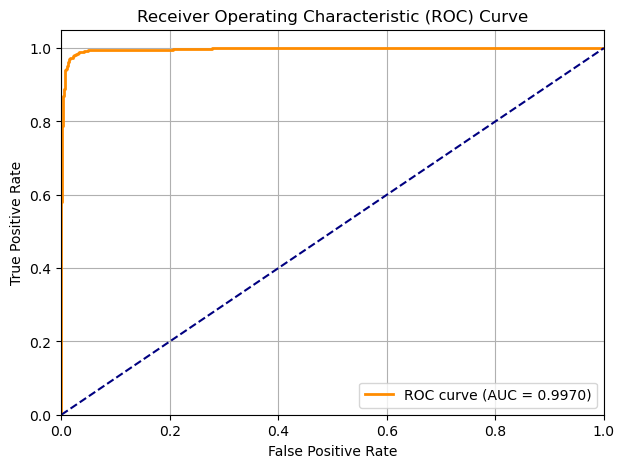

In [18]:
model.eval()
predictions, image_ids, probs = [], [], []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]

        predictions.extend(preds.cpu().numpy())
        image_ids.extend(ids)
        probs.extend(probabilities.cpu().numpy())

predictions_df = pd.DataFrame({"id": image_ids, "prediction": predictions, "probability": probs})

solutions_df["id"] = solutions_df["id"].astype(str)
predictions_df["id"] = predictions_df["id"].astype(str)
merged_df = pd.merge(predictions_df, solutions_df, on="id")

y_true = merged_df["ground_truth"]
y_pred = merged_df["prediction"]
y_prob = merged_df["probability"]

print("Classification Report:\n", classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("F1-Score:", f1_score(y_true, y_pred, average="macro"))

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [19]:
save_dir = "Models/"  
os.makedirs(save_dir, exist_ok=True) 

model_path = os.path.join(save_dir, "resnet34_internal_waves.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")


Model saved at Models/resnet34_internal_waves.pth
